In [1]:
pip install tensorflow


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

2024-07-04 13:42:40.794964: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-04 13:42:40.797749: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-04 13:42:40.806604: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-04 13:42:40.824245: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-04 13:42:40.824270: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-04 13:42:40.835882: I tensorflow/core/platform/cpu_feature_guard.cc:

In [3]:
#loading data
file_1="/workspaces/State-of-Health-Estimation-Battery/Dataset/B0005_dis_dataset.csv"
file_2="/workspaces/State-of-Health-Estimation-Battery/Dataset/B0006_dis_dataset.csv"
dataset_1=pd.read_csv(file_1)
dataset_2=pd.read_csv(file_2)

C_max=2

#renaming columns for simplicity
dataset_1.columns=['cycle',"capacity",'voltage', 'current','temperature', 'current_load', 'voltage_load',"time"]
dataset_1["current_load"]= abs(dataset_1["current_load"])

#removing ideling / starting and ending current level data  
df_1=dataset_1[(dataset_1.current_load>=0.006)].reset_index(drop=True)

# converting time seconds->hour
df_1["time"]=df_1["time"]/3600

#calculate Soc for each cycle
cycle_count=df_1["cycle"].unique()
Soc_list=[]

# Update Soc for each reading within each cycle using Coulomb counting
for cycle in cycle_count:
    cycle_data = df_1[df_1['cycle'] == cycle]
    
    cumulative_Soc = [sum(cycle_data["capacity"])/len(cycle_data["capacity"])]
    
    for i in range(1, len(cycle_data)):
        
        delta_time = cycle_data['time'].iloc[i-1] - cycle_data['time'].iloc[i]
        
        delta_charge = cycle_data['current'].iloc[i] * delta_time
        
        cumulative_Soc.append(cumulative_Soc[-1] -delta_charge)
        
    Soc_list.extend(cumulative_Soc)

#DOD is the opposite of the soc 
df_1["Soc"] = [(q / C_max) for q in Soc_list]
df_1["Soh"]=df_1["capacity"]/C_max

# selecting parameters 
att_=["cycle","capacity","voltage","current","temperature","current_load","voltage_load","time","Soc"]
att=["cycle","current_load","voltage_load","Soc","time"]
X_axis="cycle"

#seperating dataset
X_train = df_1[att]
y_train = df_1[["Soh"]]



#renaming columns for simplicity
dataset_2.columns=['cycle',"capacity",'voltage', 'current','temperature', 'current_load', 'voltage_load',"time"]
dataset_2["current_load"]= abs(dataset_2["current_load"])

#removing ideling / starting and ending current level data  
df_2=dataset_2[(dataset_2.current_load>=0.006)].reset_index(drop=True)

# converting time seconds->hour
df_2["time"]=df_2["time"]/3600

#calculate Soc for each cycle
cycle_count=df_2["cycle"].unique()
Soc_list=[]

# Update Soc for each reading within each cycle using Coulomb counting
for cycle in cycle_count:
    cycle_data = df_2[df_2['cycle'] == cycle]
    
    cumulative_Soc = [sum(cycle_data["capacity"])/len(cycle_data["capacity"])]
    
    for i in range(1, len(cycle_data)):
        
        delta_time = cycle_data['time'].iloc[i-1] - cycle_data['time'].iloc[i]
        
        delta_charge = cycle_data['current'].iloc[i] * delta_time
        
        cumulative_Soc.append(cumulative_Soc[-1] -delta_charge)
        
    Soc_list.extend(cumulative_Soc)

#DOD is the opposite of the soc 
df_2["Soc"] = [(q / C_max) for q in Soc_list]
df_2["Soh"]=df_2["capacity"]/C_max

X_test = df_2[att]
y_test = df_2[["Soh"]]

In [4]:
#define lstm model we have 4 input variable so 3 layers
#model.add(LSTM(128, activation='tanh',recurrent_activation='sigmoid',return_sequences=True,input_shape=(X_train.shape[1],1)))
# Build the LSTM model
model = Sequential()
model.add(LSTM(25, activation='tanh', recurrent_activation='sigmoid', return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.25))
model.add(LSTM(25, return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(25, return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(25))
model.add(Dropout(0.25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 5, 25)          │         2,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 25)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 5, 25)          │         5,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 25)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 5, 25)          │         5,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 25)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 25)             │         5,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,026 (70.41 KB)

 Trainable params: 18,026 (70.41 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [6]:
model.fit(X_train, y_train, epochs=200,batch_size=32, verbose=1,validation_split=0.2, callbacks=[early_stopping])

Epoch 1/200
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 0.0526 - val_loss: 4.0469e-04
Epoch 2/200
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0059 - val_loss: 1.6228e-04
Epoch 3/200
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0030 - val_loss: 2.5617e-04
Epoch 4/200
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0012 - val_loss: 5.2533e-04
Epoch 5/200
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 4.1865e-04 - val_loss: 6.7174e-04
Epoch 6/200
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 2.5730e-04 - val_loss: 1.5824e-04
Epoch 7/200
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 2.1592e-04 - val_loss: 4.6954e-04
Epoch 8/200
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 2.0551e-04 - val_loss: 5.0514e-04
Epoch 9/200
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 1.9771e-04 - val_loss: 2.9402e-04
Epoch 10/200
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 1.8470e-04 - val_loss: 3.9707e-04
Epoch 11/200
1129/1129 ━━━━━━━━━━━━━━━━━━━━

In [7]:
y_pred_1 = model.predict(X_test, verbose=1)

1387/1387 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


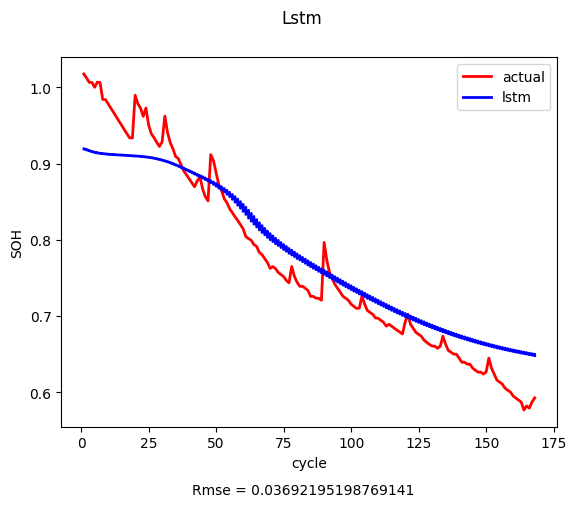

0.03692195198769141


In [8]:
plt.plot(X_test["cycle"],y_test,color='red',label='actual',linewidth=2)
plt.plot(X_test["cycle"],y_pred_1,color='blue',label="lstm",linewidth=2)
plt.xlabel("cycle")
plt.ylabel("SOH")
rmse="Rmse = "+str(np.sqrt(metrics.mean_squared_error(y_test, y_pred_1)))
plt.figtext(0.33, -0.03, rmse, fontsize=10)
plt.legend(loc="upper right")
plt.suptitle("Lstm")
plt.show()
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred_1)))

In [9]:
0.00869657655332687
0.007757341441526885

0.007757341441526885